# Workshop Part 2 of 2

At the beginning of the workshop, you were given a room name and workshop key.

Type those in the following cell, and then run the cell to assign them to global variables to be used throughout the rest of this notebook.

In [3]:
g_room_name = ""
g_workshop_key = ""

# Table of contents

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>Step 8:</b> Catch up from Part 1 of the workshop</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 9:</b> Customize NLP model for domain using dictionaries</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 10:</b> Identify entities in sticky note comments</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 11:</b> Cluster sticky notes by entities</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 12:</b> Add positional data to improve clustering</li>
<li style="margin: 0px 0px 3px 0px;"><b>Step 13:</b> Visualize clusters in the mural</li>
</ol>

# Step 8: Catch up from Part 1 of the workshop

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>8.1</b> Create a mural with sample sticky notes</li>
<li style="margin: 0px 0px 3px 0px;"><b>8.2</b> Put sticky note data into a DataFrame</li>
<li style="margin: 0px 0px 3px 0px;"><b>8.3</b> Run NLP analysis on sticky note comments</li>
</ol>

## 8.1 Create a mural with sample sticky notes

In [7]:
import requests
import json
from IPython.display import display, HTML

def setUpForPart2( room_name, workshop_key ):
    url = "https://weavesphere-mural-oauth.tqns6lm651z.us-south.codeengine.appdomain.cloud/create-mural-workshop-part2"
    headers = { "Content-Type" : "application/json", "Accept" : "application/json" }
    data = json.dumps( { "room_name" : room_name, "workshop_key" : workshop_key } )
    response = requests.request( "POST", url, headers=headers, data=data )
    response_json = response.json()
    if "error_str" in response_json:
        print( response_json["error_str"] )
        return None
    if "mural_id" not in response_json:
        print( "Field 'mural_id' not returned in result\nResult:" + json.dumps( response_json, indent=3 ) )
        return None
    if "mural_link" not in response_json:
        print( "Field 'mural_link' not returned in result\nResult:"+ json.dumps( response_json, indent=3 ) )
        return None
    if "widgets_arr" not in response_json:
        print( "Field 'widgets_arr' not returned in result\nResult:"+ json.dumps( response_json, indent=3 ) )
        return None
    mural_id = response_json["mural_id"]
    mural_link = response_json["mural_link"]
    widgets_arr = response_json["widgets_arr"]
    html = HTML( "<h3>Mural for: Workshop Part 2 of 2</h3>" + 
             "<p>Mural ID: <code>" + mural_id + "</code></p>" +
             "<p>\"Visitor\" link: <a href='" + mural_link + "' target='_other'>Click to open mural in a new tab</a></p>" )
    display( html )
    return mural_id, mural_link, widgets_arr

In [10]:
g_mural_id, g_mural_link, g_widgets_arr = setUpForPart2( g_room_name, g_workshop_key )

## 8.2 Put sticky note data into a DataFrame

In [16]:
import pandas as pd

widgets_df_full = pd.DataFrame( g_widgets_arr )
g_stickies_df = widgets_df_full[ widgets_df_full["type"] == "sticky-note" ].copy()
g_stickies_df = g_stickies_df[["id","x", "y","width","height","text"]].reset_index( drop=True )
g_stickies_df

,id,x,y,width,height,text
0,a585378c-88d0-4860-bc91-037c63777f00,2875.12,4611.08,830.000000,830.000000,Lunch at the restaurant was great!
1,26930d3d-a76a-4dff-94e5-c28012ae2a8a,857.12,4750.10,860.000000,860.000000,Restaurant was far away
2,ba2c2173-3431-4d9b-b586-b9c0642dad88,8725.15,3011.00,787.000000,787.000000,Mini-golf is hilarious - we were getting prett...
3,63d0fff5-839a-4cb7-9829-6a3427d70e00,5066.00,2678.00,748.000000,748.000000,Minigolf is lame
4,f8fd276c-26fa-42a6-b9b2-44e6a106c009,520.00,3309.00,904.000000,904.000000,Yummy food
5,34f4d24d-094b-418a-86d4-2790c5659b20,2435.12,3961.93,855.000000,855.000000,Food was ok
6,afd4eb11-e112-4120-a7cc-78012bee49c7,5673.94,4775.94,872.000000,872.000000,The minigolf was boring
7,a994063d-fd26-4c12-be68-674f88fb497e,3453.46,1655.50,670.000000,670.000000,Disapointed by no vegetarian choices
8,f55d733e-f501-4f78-b82e-b53588feac82,1846.61,1740.00,915.000000,915.000000,Waiter at the restaurant was funny
9,7bf01bf5-173a-4b31-b2d9-b47b962e45e3,-26.88,1877.99,978.007054,978.007054,Choose a restaurant with a vegetarian menu


## 8.3 Run NLP analysis on sticky note comments

In [18]:
import watson_nlp
from watson_nlp.toolkit import predict_document_sentiment

g_syntax_model = watson_nlp.load( watson_nlp.download( "syntax_izumo_en_stock" ) )
print( "Done" )

Done


In [19]:
g_sentiment_model = watson_nlp.load( watson_nlp.download( "sentiment_sentence-bert_multi_stock" ) )
print( "Done" )

Done


In [20]:
import re

def analyzeComment( comment ):
    syntax_result = g_syntax_model.run( comment )
    sentiment_result  = g_sentiment_model.run_batch( syntax_result.get_sentence_texts(), syntax_result.sentences )
    document_sentiment = predict_document_sentiment( sentiment_result, g_sentiment_model.class_idxs )
    sentiment_dict = document_sentiment.to_dict()
    sentiment_dict["label"] = re.sub( r"^.*_", "", sentiment_dict["label"].lower() ).title()
    return sentiment_dict

def generateSentimentColumns( row ):
    comment = row["text"]
    sentiment_dict = analyzeComment( comment )
    return sentiment_dict["label"], sentiment_dict["score"]

def getPOS( tokens_arr ):
    result = { "POS_NOUN" : [], "POS_VERB" : [], "POS_ADJ" : [], "POS_ADV" : [] }
    for token in tokens_arr:
        txt = token["lemma"] if token["lemma"] else token["span"]["text"].lower()
        pos = token["part_of_speech"]
        if pos in result.keys():
            result[ pos ].append( txt )
    return result

def generateSyntaxColumns( row ):
    comment = row["text"]
    syntax_dict = g_syntax_model.run( comment, parsers=( "token", "lemma", "part_of_speech" ) ).to_dict()
    pos = getPOS( syntax_dict["tokens"] )
    return pos["POS_NOUN"], pos["POS_ADJ"]

In [21]:
g_stickies_w_sentiment_df = g_stickies_df.copy()
g_stickies_w_sentiment_df[ [ "SENTIMENT", "SENTIMENT_SCORE" ] ] = g_stickies_w_sentiment_df.apply ( generateSentimentColumns, axis=1, result_type="expand" )
g_stickies_w_pos_df = g_stickies_w_sentiment_df.copy()
g_stickies_w_pos_df[ [ "NOUNS", "ADJECTIVES" ] ] = g_stickies_w_pos_df.apply ( generateSyntaxColumns, axis=1, result_type="expand" )
g_stickies_w_pos_df

,id,x,y,width,height,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES
0,a585378c-88d0-4860-bc91-037c63777f00,2875.12,4611.08,830.000000,830.000000,Lunch at the restaurant was great!,Positive,0.969829,"[lunch, restaurant]",[great]
1,26930d3d-a76a-4dff-94e5-c28012ae2a8a,857.12,4750.10,860.000000,860.000000,Restaurant was far away,Negative,-0.684768,[restaurant],[]
2,ba2c2173-3431-4d9b-b586-b9c0642dad88,8725.15,3011.00,787.000000,787.000000,Mini-golf is hilarious - we were getting prett...,Positive,0.996129,"[golf, score]","[hilarious, competitive]"
3,63d0fff5-839a-4cb7-9829-6a3427d70e00,5066.00,2678.00,748.000000,748.000000,Minigolf is lame,Negative,-0.923597,[],[lame]
4,f8fd276c-26fa-42a6-b9b2-44e6a106c009,520.00,3309.00,904.000000,904.000000,Yummy food,Positive,0.956058,[food],[yummy]
5,34f4d24d-094b-418a-86d4-2790c5659b20,2435.12,3961.93,855.000000,855.000000,Food was ok,Neutral,0.000000,[food],[ok]
6,afd4eb11-e112-4120-a7cc-78012bee49c7,5673.94,4775.94,872.000000,872.000000,The minigolf was boring,Negative,-0.936382,[minigolf],[boring]
7,a994063d-fd26-4c12-be68-674f88fb497e,3453.46,1655.50,670.000000,670.000000,Disapointed by no vegetarian choices,Negative,-0.915829,[choice],[vegetarian]
8,f55d733e-f501-4f78-b82e-b53588feac82,1846.61,1740.00,915.000000,915.000000,Waiter at the restaurant was funny,Positive,0.897118,"[waiter, restaurant]",[funny]
9,7bf01bf5-173a-4b31-b2d9-b47b962e45e3,-26.88,1877.99,978.007054,978.007054,Choose a restaurant with a vegetarian menu,Neutral,0.000000,"[restaurant, menu]",[vegetarian]


# Step 9: Customize NLP model for domain using dictionaries

The Watson NLP library provides a mechanism to easily create dictionaries of domain-specific terms and then extract entities from text using those dictionaries.

See: [Detecting entities with a custom dictionary](https://dataplatform.cloud.ibm.com/docs/content/wsj/analyze-data/watson-nlp-entities-dict.html?context=cpdaas&audience=wdp)

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>9.1</b> Create a directory for custom dictionary files</li>
<li style="margin: 0px 0px 3px 0px;"><b>9.2</b> Create a dictionary file for lunch-related terms</li>
<li style="margin: 0px 0px 3px 0px;"><b>9.3</b> Create a dictionary file for golf-related terms</li>
<li style="margin: 0px 0px 3px 0px;"><b>9.4</b> Create custom dictionaries</li>
<li style="margin: 0px 0px 3px 0px;"><b>9.5</b> Test extracting entities using custom dictionaries</li>
</ol>

## 9.1 Create a directory for custom dictionary files

In [24]:
import os
dictionaries_dir = "Custom_NLP" 
os.makedirs( dictionaries_dir, exist_ok=True )
print( "Done")

Done


## 9.2 Create a dictionary file for lunch-related terms

In [25]:
lunch_file = 'lunch.csv'
with open( os.path.join( dictionaries_dir, lunch_file ), 'w' ) as table:
    table.write( "\"label\", \"entry\"\n" )
    table.write( "\"LOCATION\", \"far\"\n" )
    table.write( "\"MENU\", \"vegetarian\"\n" )
    table.write( "\"SERVICE\", \"service\"\n" )
    table.write( "\"SERVICE\", \"slow\"\n" )
    table.write( "\"SERVICE\", \"waiter\"\n" )
    table.write( "\"FOOD\", \"food\"\n" )
    table.write( "\"FOOD\", \"bread\"\n" )
    table.write( "\"FOOD\", \"fresh\"\n" )
    table.write( "\"LUNCH\", \"lunch\"\n" )
print( "Done" )

Done


## 9.3 Create a dictionary file for golf-related terms

In [26]:
golf_file = 'mini-golf.csv'
with open( os.path.join( dictionaries_dir, golf_file ), 'w' ) as table:
    table.write( "\"label\", \"entry\"\n" )
    table.write( "\"GOLF\", \"mini-golf\"\n" )
    table.write( "\"GOLF\", \"minigolf\"\n" )
    table.write( "\"GOLF\", \"golf\"\n" )
    table.write( "\"PLAY\", \"hole in one\"\n" )
    table.write( "\"WEATHER\", \"weather\"\n" )
    table.write( "\"WEATHER\", \"rain\"\n" )
    table.write( "\"COURSE\", \"golf course\"\n" )
    table.write( "\"COURSE\", \"course\"\n" )
print( "Done" )

Done


## 9.4 Create custom dictionaries

In [27]:
import watson_nlp

lunch_config = {
    "name"   : "lunch",
    "source" : lunch_file,
    "dict_type" : "table",
    "mappings": { "columns": [ "label", "entry" ], "entry" : "entry" },
    "consolidate" : "ContainedWithin",
    "case"        : "insensitive"
}

golf_config = {
    "name"   : "golf",
    "source" : golf_file,
    "dict_type" : "table",
    "mappings": { "columns": [ "label", "entry" ], "entry" : "entry" },
    "consolidate" : "ContainedWithin",
    "case"        : "insensitive"
}

dict_arr = watson_nlp.toolkit.DictionaryConfig.load_all( [ lunch_config, golf_config ] )

g_custom_dictionaries = watson_nlp.resources.feature_extractor.RBR.train( 
    dictionaries_dir,
    language = "en", 
    dictionaries = dict_arr
)

print( "Done" )

Done


## 9.5 Test extracting entities using custom dictionaries

In [28]:
import json

# Testing ...
comment = "The golf course was really great"
entities_result = g_custom_dictionaries.executor.get_raw_response( comment, language = "en" )
print( json.dumps( entities_result["annotations"], indent=3 ) )

{
   "View_lunch": [],
   "View_golf": [
      {
         "label": "COURSE",
         "match": {
            "location": {
               "begin": 4,
               "end": 15
            },
            "text": "golf course"
         }
      }
   ]
}


# Step 10: Identify entities in sticky note comments

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>10.1:</b> Define function to extract entities in a DataFrame</li>
<li style="margin: 0px 0px 3px 0px;"><b>10.2:</b> Extract entities in the sticky notes DataFrame</li>
</ol>

## 10.1 Define function to extract entities in a DataFrame

In [29]:
import re

def getTopEntities( entities_raw ):
    entities = {}
    dictionary_names = [ "LUNCH", "GOLF" ]
    for category in entities_raw["annotations"].keys():
        catgory_name = re.sub( r"^.+\_", "", category ).upper();
        if catgory_name not in entities:
            entities[ catgory_name ] = []
        for match in entities_raw["annotations"][category]:
            label = match["label"]
            if ( label not in dictionary_names ) and ( label not in entities[ catgory_name ] ):
                entities[ catgory_name ].append( label )
    top_category, top_entities = max( entities.items(), key = lambda x: len(set(x[1])) )
    result = { "DICTIONARY" : "", "ENTITIES" : [] }
    if len( top_entities ) > 0:
        result = { "DICTIONARY" : top_category, "ENTITIES" : top_entities }
    return result
    
def generateEntitiesColumns( row ):
    comment = row["text"]
    entities_raw = g_custom_dictionaries.executor.get_raw_response( comment, language = "en" )
    entities_dict = getTopEntities( entities_raw )
    return entities_dict["DICTIONARY"], entities_dict["ENTITIES"]

In [30]:
test_df = g_stickies_w_pos_df[0:2].copy();
test_df

,id,x,y,width,height,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES
0,a585378c-88d0-4860-bc91-037c63777f00,2875.12,4611.08,830.0,830.0,Lunch at the restaurant was great!,Positive,0.969829,"[lunch, restaurant]",[great]
1,26930d3d-a76a-4dff-94e5-c28012ae2a8a,857.12,4750.10,860.0,860.0,Restaurant was far away,Negative,-0.684768,[restaurant],[]


In [31]:
test_df[ [ "DICTIONARY", "ENTITIES" ] ] = test_df.apply ( generateEntitiesColumns, axis=1, result_type="expand" )
test_df

,id,x,y,width,height,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES,DICTIONARY,ENTITIES
0,a585378c-88d0-4860-bc91-037c63777f00,2875.12,4611.08,830.0,830.0,Lunch at the restaurant was great!,Positive,0.969829,"[lunch, restaurant]",[great],,[]
1,26930d3d-a76a-4dff-94e5-c28012ae2a8a,857.12,4750.10,860.0,860.0,Restaurant was far away,Negative,-0.684768,[restaurant],[],LUNCH,[LOCATION]


## 10.2 Extract entities in the sticky notes DataFrame

In [32]:
g_stickies_w_entities_df = g_stickies_w_pos_df.copy()
g_stickies_w_entities_df[ [ "DICTIONARY", "ENTITIES" ] ] = g_stickies_w_entities_df.apply ( generateEntitiesColumns, axis=1, result_type="expand" )
g_stickies_w_entities_df[ [ "text", "SENTIMENT", "SENTIMENT_SCORE", "NOUNS", "ADJECTIVES", "DICTIONARY", "ENTITIES" ] ]

,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES,DICTIONARY,ENTITIES
0,Lunch at the restaurant was great!,Positive,0.969829,"[lunch, restaurant]",[great],,[]
1,Restaurant was far away,Negative,-0.684768,[restaurant],[],LUNCH,[LOCATION]
2,Mini-golf is hilarious - we were getting prett...,Positive,0.996129,"[golf, score]","[hilarious, competitive]",,[]
3,Minigolf is lame,Negative,-0.923597,[],[lame],,[]
4,Yummy food,Positive,0.956058,[food],[yummy],LUNCH,[FOOD]
5,Food was ok,Neutral,0.000000,[food],[ok],LUNCH,[FOOD]
6,The minigolf was boring,Negative,-0.936382,[minigolf],[boring],,[]
7,Disapointed by no vegetarian choices,Negative,-0.915829,[choice],[vegetarian],LUNCH,[MENU]
8,Waiter at the restaurant was funny,Positive,0.897118,"[waiter, restaurant]",[funny],LUNCH,[SERVICE]
9,Choose a restaurant with a vegetarian menu,Neutral,0.000000,"[restaurant, menu]",[vegetarian],LUNCH,[MENU]


# Step 11: Cluster sticky notes by entities

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>11.1</b> Define function to cluster sticky note comments by entity</li>
<li style="margin: 0px 0px 3px 0px;"><b>11.2</b> Visualize how clustering works</li>
<li style="margin: 0px 0px 3px 0px;"><b>11.3</b> Cluster sticky note comments by entity</li>
</ol>

## 11.1 Define function to cluster sticky note comments by entity

Build a *dendrogram* to perform *hierarchical clustering* of comments based on the extracted entities.

<!-- See: [scipy.cluster.hierarchy.dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html) -->


In [33]:
from collections import OrderedDict
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
from scipy import cluster

def countWords( df, col_name, min_count ):
    all_words = {}
    for index, row in df.iterrows():
        words_arr = row[ col_name ]
        for word in words_arr:
            if word not in all_words:
                all_words[word] = 0
            all_words[word] += 1
    common_words = dict( [ (k,v) for k,v in all_words.items() if v > min_count ] )
    ordered_common_words = OrderedDict( sorted( common_words.items(), key=lambda x:x[1], reverse=True ) )
    return ordered_common_words

def uniqueWords( df, col_name, min_count ):
    words_od = countWords( df, col_name, min_count )
    unique_words = list( words_od.keys() )
    return sorted( unique_words )

def buildWordsMatrix( df, col_name, min_count ):
    unique_words = uniqueWords( df, col_name, min_count )
    labels = []
    matrix = []
    indices_org = []
    omitted_indices = []
    for index, df_row in df.iterrows():
        label_arr = []
        matrix_row = []
        for word in unique_words:
            if word in df_row[ col_name ]:
                label_arr.append( word )
                matrix_row.append( 1 )
            else:
                matrix_row.append( 0 )
        if( len( label_arr ) > 0 ):
            labels.append( " | ".join( label_arr ) )
            matrix.append( matrix_row )
            indices_org.append( index )
        else:
            omitted_indices.append( index )
    return labels, matrix, indices_org, omitted_indices, unique_words

def printExplanation( unique_labels, matrix, indices, df ):
    maxlen = len( max( unique_labels, key=len ) ) + 2
    print( "".join( [ label.rjust( maxlen ) for label in unique_labels ] ) )
    for i in range( len( matrix ) ):
        row = list( matrix[i] )
        row_str = "".join( [ str( entry ).rjust( maxlen ) for entry in row ] )
        print( row_str + "  " + df.loc[indices[i],"text"] )

def addClusterH( df, col_name, Z, labels, indices_org, omitted_indices ):
    cutree = cluster.hierarchy.cut_tree( Z, height=1.25 )
    cluster_arr = []
    for i in range( len(cutree) ):
        cluster_num = cutree[i][0]
        label = labels[i]
        index = indices_org[i]
        row = df.iloc[index]
        cluster_arr.append( list( row ) + [ cluster_num, label ] )
    other_cluster_num = int( max( cutree ) + 1 )
    for index in omitted_indices:
        row = df.iloc[index]
        cluster_arr.append( list( row ) + [ other_cluster_num, " | ".join( row[ col_name ] ) ] )
    clusterH_df = pd.DataFrame( cluster_arr, columns = df.columns.tolist() + [ "H_CLUSTER_ID", "LABEL" ] )
    return clusterH_df

def clusterH( df, col_name, explain=False ):
    labels, matrix, indices_org, omitted_indices, unique_words = buildWordsMatrix( df, col_name, 0 )
    if explain:
        printExplanation( unique_words, matrix, indices_org, df )
        return;
    Z = linkage( matrix, "single" )
    plt.figure( figsize=( 5, 8 ) )
    plt.gca().spines["left"].set_visible(False)
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    dend = dendrogram( Z,
                       get_leaves=True,
                       orientation="left",
                       labels=labels,
                       leaf_font_size=12,
                       show_leaf_counts=True)
    plt.show()
    clusterH_df = addClusterH( df, col_name, Z, labels, indices_org, omitted_indices )
    return clusterH_df.sort_values( [ "H_CLUSTER_ID", "LABEL" ], ignore_index=True )

## 11.2 Visualize how clustering works

In [34]:
clusterH( g_stickies_w_entities_df, "ENTITIES", explain=True )

    COURSE      FOOD  LOCATION      MENU      PLAY   SERVICE   WEATHER
         0         0         1         0         0         0         0  Restaurant was far away
         0         1         0         0         0         0         0  Yummy food
         0         1         0         0         0         0         0  Food was ok
         0         0         0         1         0         0         0  Disapointed by no vegetarian choices
         0         0         0         0         0         1         0  Waiter at the restaurant was funny
         0         0         0         1         0         0         0  Choose a restaurant with a vegetarian menu
         0         0         0         0         0         1         0  Restaurant service was slow
         0         1         0         0         0         0         0  Bread was so warm and fresh!
         0         0         0         0         1         0         0  I got a hole in one
         0         0         0         0  

## 11.3 Cluster sticky note comments by entity

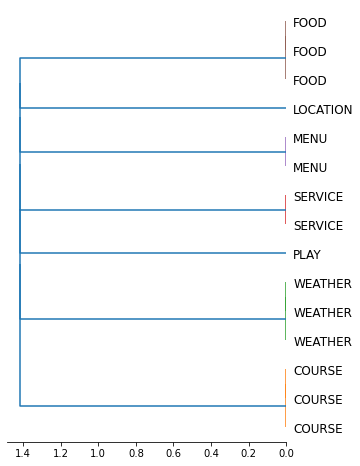

In [35]:
g_stickies_w_cluster_df = clusterH( g_stickies_w_entities_df, "ENTITIES" )

In [36]:
g_stickies_w_cluster_df.iloc[:,5:]

,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES,DICTIONARY,ENTITIES,H_CLUSTER_ID,LABEL
0,Restaurant was far away,Negative,-0.684768,[restaurant],[],LUNCH,[LOCATION],0,LOCATION
1,Yummy food,Positive,0.956058,[food],[yummy],LUNCH,[FOOD],1,FOOD
2,Food was ok,Neutral,0.000000,[food],[ok],LUNCH,[FOOD],1,FOOD
3,Bread was so warm and fresh!,Positive,0.979435,[bread],"[warm, fresh]",LUNCH,[FOOD],1,FOOD
4,Disapointed by no vegetarian choices,Negative,-0.915829,[choice],[vegetarian],LUNCH,[MENU],2,MENU
5,Choose a restaurant with a vegetarian menu,Neutral,0.000000,"[restaurant, menu]",[vegetarian],LUNCH,[MENU],2,MENU
6,Waiter at the restaurant was funny,Positive,0.897118,"[waiter, restaurant]",[funny],LUNCH,[SERVICE],3,SERVICE
7,Restaurant service was slow,Negative,-0.858261,"[restaurant, service]",[slow],LUNCH,[SERVICE],3,SERVICE
8,I got a hole in one,Neutral,0.000000,[hole],[],GOLF,[PLAY],4,PLAY
9,The weather kind-of ruined the mini-golf,Negative,-0.977617,"[weather, mini, golf]",[kind],GOLF,[WEATHER],5,WEATHER


# Step 12: Add positional data to improve clustering

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>12.1</b> List shapes in the mural</li>
<li style="margin: 0px 0px 3px 0px;"><b>12.2</b> Identify the "Lunch" box and the "Mini-golf" box widgets</li>
<li style="margin: 0px 0px 3px 0px;"><b>12.3</b> Identify which box - "Lunch" or "Mini-golf" - a sticky note is closest to</li>
<li style="margin: 0px 0px 3px 0px;"><b>12.4</b> Cluster with entities and positional data</li>
</ol>

## 12.1 List shapes in the mural

In [39]:
import requests

def refreshAccessToken( room_name, workshop_key ):
    url = "https://weavesphere-mural-oauth.tqns6lm651z.us-south.codeengine.appdomain.cloud/refresh-token"
    headers = { "Content-Type" : "application/json", "Accept" : "application/json" }
    data = json.dumps( { "room_name" : room_name, "workshop_key" : workshop_key } )
    response = requests.request( "POST", url, headers=headers, data=data )
    response_json = response.json()
    if "error_str" in response_json:
        print( response_json["error_str"] )
        return None
    if "access_token" not in response_json:
        print( "Field 'access_token' not returned in result" )
        return None
    return response_json["access_token"]

def listShapes( room_name, workshop_key, mural_id  ):
    mural_oauth_token = refreshAccessToken( room_name, workshop_key )
    if mural_oauth_token is None:
        return
    # https://developers.mural.co/public/reference/getmuralwidgets
    url = "https://app.mural.co/api/public/v1/murals/" + mural_id + "/widgets?type=shapes"
    headers = { "Content-Type" : "application/json", "Accept": "application/json", "Authorization": "Bearer " + mural_oauth_token }
    response = requests.request( "GET", url, headers = headers )
    response_json = response.json()
    msg = ""
    if "code" in response_json:
        msg += response_json["code"] + " "
    if "message" in response_json:
        msg += response_json["message"]
    if msg != "":
        print( msg )
        return None
    if "value" not in response_json:
        print( "No value returned" )
        return None
    return response_json["value"]

In [ ]:
g_shapes_arr = listShapes( g_room_name, g_workshop_key, g_mural_id  )
print( json.dumps( g_shapes_arr, indent=3 ) )

## 12.2 Identify the "Lunch" box and the "Mini-golf" box widgets

Both the rectangle shape for the feedback comments about lunch and the one for comments about mini-golf had a title and a description added to the mural outline.

That means the JSON for those widgets has a non-empty value for `title` and `instruction`.

See: [Organize your mural with the outline feature](https://support.mural.co/en/articles/2113749-organize-your-mural-with-the-outline-feature)

In [41]:
def getLunchAndMinigolfBoxes( widgets_arr ):
    lunch_widget = None
    golf_widget = None
    for widget in widgets_arr:
        widget_copy = { "id" : widget["id"],
                        "x"  : widget["x"],
                        "y"  : widget["y"],
                        "height" : widget["height"],
                        "width"  : widget["width"] }
        if ( "title" in widget ) and re.match( r".*lunch", widget["title"], re.IGNORECASE ):
            lunch_widget = widget_copy
        elif ( "title" in widget ) and re.match( r".*golf", widget["title"], re.IGNORECASE ):
            golf_widget = widget_copy
        if ( None != lunch_widget ) and ( None != golf_widget ):
            break;
    return lunch_widget, golf_widget

In [42]:
g_lunch_widget, g_golf_widget = getLunchAndMinigolfBoxes( g_shapes_arr )
print( "Done" )

Done


In [43]:
print( json.dumps( { "lunch_widget" : g_lunch_widget, "golf_widget" : g_golf_widget }, indent=3 ) )

{
   "lunch_widget": {
      "id": "2dee0855-8fb8-4ba5-aa3e-d4ab35d5d026",
      "x": 331.81,
      "y": 402.09,
      "height": 5441.890554077407,
      "width": 4076.6122634755434
   },
   "golf_widget": {
      "id": "ad1ea041-80ee-4cb9-9f2e-3e5e5c9c2490",
      "x": 4803.34,
      "y": 410.16,
      "height": 5441.890554077407,
      "width": 4076.6122634755434
   }
}


## 12.3 Identify which box - "Lunch" or "Mini-golf" - a sticky note is closest to

In [44]:
def stickyCategory( row ):
    sticky_center_x = row["x"]  + ( 0.5 * row["width"] )
    lunch_center_x  = g_lunch_widget["x"] + ( 0.5 * g_lunch_widget["width"] )
    golf_center_x   = g_golf_widget["x"]  + ( 0.5 * g_golf_widget["width"] )
    lunch_distance  = abs( sticky_center_x - lunch_center_x )
    golf_distance   = abs( sticky_center_x - golf_center_x )
    return "LUNCH" if ( lunch_distance < golf_distance ) else "GOLF"

In [45]:
row = g_stickies_w_cluster_df.iloc[0]
print( row["text"] )
stickyCategory( row )

Restaurant was far away


'LUNCH'

In [46]:
g_stickies_w_category_df = g_stickies_w_cluster_df.copy()
g_stickies_w_category_df["category_box"] = g_stickies_w_category_df.apply( stickyCategory, axis=1 )
g_stickies_w_category_df.iloc[:,5:]

,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES,DICTIONARY,ENTITIES,H_CLUSTER_ID,LABEL,category_box
0,Restaurant was far away,Negative,-0.684768,[restaurant],[],LUNCH,[LOCATION],0,LOCATION,LUNCH
1,Yummy food,Positive,0.956058,[food],[yummy],LUNCH,[FOOD],1,FOOD,LUNCH
2,Food was ok,Neutral,0.000000,[food],[ok],LUNCH,[FOOD],1,FOOD,LUNCH
3,Bread was so warm and fresh!,Positive,0.979435,[bread],"[warm, fresh]",LUNCH,[FOOD],1,FOOD,LUNCH
4,Disapointed by no vegetarian choices,Negative,-0.915829,[choice],[vegetarian],LUNCH,[MENU],2,MENU,LUNCH
5,Choose a restaurant with a vegetarian menu,Neutral,0.000000,"[restaurant, menu]",[vegetarian],LUNCH,[MENU],2,MENU,LUNCH
6,Waiter at the restaurant was funny,Positive,0.897118,"[waiter, restaurant]",[funny],LUNCH,[SERVICE],3,SERVICE,LUNCH
7,Restaurant service was slow,Negative,-0.858261,"[restaurant, service]",[slow],LUNCH,[SERVICE],3,SERVICE,LUNCH
8,I got a hole in one,Neutral,0.000000,[hole],[],GOLF,[PLAY],4,PLAY,GOLF
9,The weather kind-of ruined the mini-golf,Negative,-0.977617,"[weather, mini, golf]",[kind],GOLF,[WEATHER],5,WEATHER,GOLF


### Clarity!

Now, even ambiguous comments, like "So fun!" and "Let's do it again!", have some context.  

Given their position on the mural, you at least know whether the comment is referring to lunch or mini-golf.  

You could not figure that out using only NLP.  Even a human couldn't guess what those comments were referring to.  But MURAL's positional information can tell us for sure.

## 12.4 Cluster with entities and positional data

In [47]:
g_lunch_stickies_w_entities_df = g_stickies_w_category_df[ g_stickies_w_category_df["category_box"] == "LUNCH" ].copy().reset_index(drop=True).drop( [ "LABEL", "H_CLUSTER_ID" ], axis=1 )
g_golf_stickies_w_entities_df = g_stickies_w_category_df[ g_stickies_w_category_df["category_box"] == "GOLF" ].copy().reset_index(drop=True).drop( [ "LABEL", "H_CLUSTER_ID" ], axis=1 )
print( "Done" )

Done


### Position: Lunch rectangle

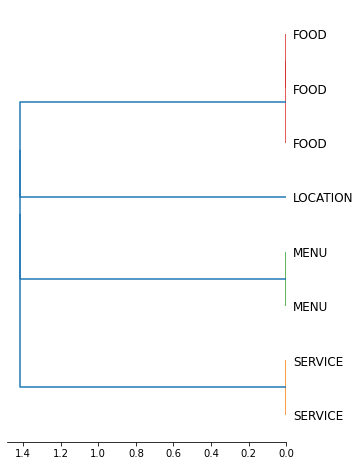

In [48]:
g_lunch_stickies_w_cluster_df = clusterH( g_lunch_stickies_w_entities_df, "ENTITIES" )

In [49]:
g_lunch_stickies_w_cluster_df["LABEL"] = g_lunch_stickies_w_cluster_df["LABEL"].replace( "", "GENERAL" )
g_lunch_stickies_w_cluster_df.iloc[:,5:]

,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES,DICTIONARY,ENTITIES,category_box,H_CLUSTER_ID,LABEL
0,Restaurant was far away,Negative,-0.684768,[restaurant],[],LUNCH,[LOCATION],LUNCH,0,LOCATION
1,Yummy food,Positive,0.956058,[food],[yummy],LUNCH,[FOOD],LUNCH,1,FOOD
2,Food was ok,Neutral,0.000000,[food],[ok],LUNCH,[FOOD],LUNCH,1,FOOD
3,Bread was so warm and fresh!,Positive,0.979435,[bread],"[warm, fresh]",LUNCH,[FOOD],LUNCH,1,FOOD
4,Disapointed by no vegetarian choices,Negative,-0.915829,[choice],[vegetarian],LUNCH,[MENU],LUNCH,2,MENU
5,Choose a restaurant with a vegetarian menu,Neutral,0.000000,"[restaurant, menu]",[vegetarian],LUNCH,[MENU],LUNCH,2,MENU
6,Waiter at the restaurant was funny,Positive,0.897118,"[waiter, restaurant]",[funny],LUNCH,[SERVICE],LUNCH,3,SERVICE
7,Restaurant service was slow,Negative,-0.858261,"[restaurant, service]",[slow],LUNCH,[SERVICE],LUNCH,3,SERVICE
8,Lunch at the restaurant was great!,Positive,0.969829,"[lunch, restaurant]",[great],,[],LUNCH,4,GENERAL
9,It was nice to go out for lunch all together,Positive,0.972291,[lunch],[nice],,[],LUNCH,4,GENERAL


### Position: Golf rectangle

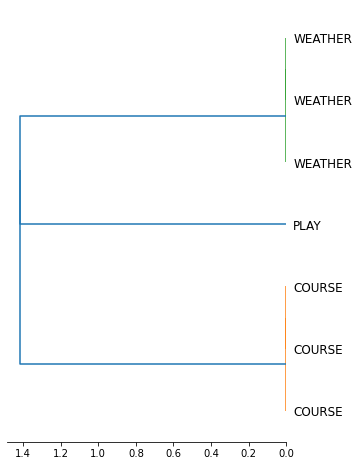

In [50]:
g_golf_stickies_w_cluster_df = clusterH( g_golf_stickies_w_entities_df, "ENTITIES" )

In [51]:
g_golf_stickies_w_cluster_df["LABEL"] = g_golf_stickies_w_cluster_df["LABEL"].replace( "", "GENERAL" )
g_golf_stickies_w_cluster_df.iloc[:,5:]

,text,SENTIMENT,SENTIMENT_SCORE,NOUNS,ADJECTIVES,DICTIONARY,ENTITIES,category_box,H_CLUSTER_ID,LABEL
0,I got a hole in one,Neutral,0.000000,[hole],[],GOLF,[PLAY],GOLF,0,PLAY
1,The weather kind-of ruined the mini-golf,Negative,-0.977617,"[weather, mini, golf]",[kind],GOLF,[WEATHER],GOLF,1,WEATHER
2,Was a beautiful day and lovely weather for min...,Positive,0.990025,"[day, weather]","[beautiful, lovely]",GOLF,[WEATHER],GOLF,1,WEATHER
3,Too bad about the rain,Negative,-0.965051,[rain],[bad],GOLF,[WEATHER],GOLF,1,WEATHER
4,The course was really fun,Positive,0.992697,[course],[fun],GOLF,[COURSE],GOLF,2,COURSE
5,The golf course was a hoot!,Positive,0.870856,"[golf, course, hoot]",[],GOLF,[COURSE],GOLF,2,COURSE
6,Fun little course,Positive,0.996067,[course],[little],GOLF,[COURSE],GOLF,2,COURSE
7,Mini-golf is hilarious - we were getting prett...,Positive,0.996129,"[golf, score]","[hilarious, competitive]",,[],GOLF,3,GENERAL
8,Minigolf is lame,Negative,-0.923597,[],[lame],,[],GOLF,3,GENERAL
9,The minigolf was boring,Negative,-0.936382,[minigolf],[boring],,[],GOLF,3,GENERAL


# Step 13: Visualize clusters in the mural

<ol style="list-style: none; margin: 20px 0px 0px 0px; padding: 0px">
<li style="margin: 0px 0px 3px 0px;"><b>13.1:</b> Divide each category box into cluster zones</li>
<li style="margin: 0px 0px 3px 0px;"><b>13.2:</b> Define routines to add cluster label and move stickies</li>
<li style="margin: 0px 0px 3px 0px;"><b>13.3:</b> Move sticky notes into labeled clusters in the mural</li>
<li style="margin: 0px 0px 3px 0px;"><b>13.3:</b> [Optional] Routine for resetting the sticky notes</li>
</ol>

## 13.1 Divide each category box into cluster zones

In [52]:
def getClusterZones( box, cluster_df ):
    title_padding = 450
    label_padding = 550
    padding = 50
    box_top = box["y"]
    box_height = box["height"]
    box_bottom = box_top + box_height
    box_left = box["x"]
    box_width = box["width"]
    box_right = box_left + box_width
    cluster_labels_df = cluster_df.loc[:,["LABEL","H_CLUSTER_ID"]].copy().drop_duplicates( subset=["LABEL","H_CLUSTER_ID"], keep="first")
    cluster_counts_df = cluster_df.loc[ :, [ "H_CLUSTER_ID" ] ].copy()
    cluster_counts_df["cluster_count"] = 0
    cluster_counts_df = cluster_counts_df.groupby( [ "H_CLUSTER_ID" ], as_index=False ).count()
    cluster_labels_df["cluster_count"] = cluster_labels_df.H_CLUSTER_ID.map( cluster_counts_df.set_index( "H_CLUSTER_ID" )["cluster_count"] )
    num_clusters = cluster_labels_df.shape[0]
    zone_height = ( box_bottom - box_top - title_padding ) / ( num_clusters - 0.25 )
    cluster_zones = {}
    zone_top = box_top + title_padding
    for index, row in cluster_labels_df.iterrows():
        label = row["LABEL"] if re.match( r"\S", row["LABEL"] ) else "GENERAL"
        cluster_zones[ label ] = { "x" : round( box_left + label_padding ), "y" : round( zone_top ), "height" : round( zone_height ), "width" : round( box_width ) }
        zone_top += zone_height
    return cluster_zones

### Lunch cluster zones

In [ ]:
lunch_cluster_zones = getClusterZones( g_lunch_widget, g_lunch_stickies_w_cluster_df )
print( json.dumps( lunch_cluster_zones, indent=3 ) )

### Golf cluster zones

In [ ]:
golf_cluster_zones = getClusterZones( g_golf_widget, g_golf_stickies_w_cluster_df )
print( json.dumps( golf_cluster_zones, indent=3 ) )

## 13.2 Define routines to add cluster label and move stickies

In [55]:
from random import randrange

g_label_padding = 550
g_padding = 50

def addLabel( label, zone, mural_oauth_token ):
    # https://developers.mural.co/public/reference/createtextbox
    widget_data = { "x" : zone["x"] + g_padding - g_label_padding, 
                    "y" : zone["y"], 
                    "width" : 500,
                    "text" : "<b>" + label + "</b>",
                    "style": { "fontSize": 100 }
                  }
    url = "https://app.mural.co/api/public/v1/murals/" + g_mural_id + "/widgets/textbox"
    headers = { "Content-Type" : "application/json", "Accept" : "vnd.mural.preview", "Authorization" : "Bearer " + mural_oauth_token }
    data = json.dumps( widget_data )
    response = requests.request( "POST", url, headers=headers, data=data )
    response_json = response.json()
    msg = ""
    if "code" in response_json:
        msg += response_json["code"] + " "
    if "message" in response_json:
        msg += response_json["message"]
    return msg

def moveSticky( sticky_id, x, y, mural_oauth_token ):
    # https://developers.mural.co/public/reference/updatestickynote
    url = "https://app.mural.co/api/public/v1/murals/" + g_mural_id + "/widgets/sticky-note/" + sticky_id
    headers = { "Content-Type" : "application/json", "Accept" : "application/json", "Authorization" : "Bearer " + mural_oauth_token }
    data = json.dumps( { "x" : x, "y" : y } )
    response = requests.request( "PATCH", url, headers=headers, data=data )
    response_json = json.loads( response.text )
    msg = ""
    if "code" in response_json:
        msg += response_json["code"] + " "
    if "message" in response_json:
        msg += response_json["message"]
    if msg != "":
        print( msg )

def lineUpInZone( zone, stickies_df, mural_oauth_token ):
    zone_padding = 0.05 * zone["height"]
    top_edge = zone["y"]
    left_edge = zone["x"] + zone_padding
    right_edge = left_edge
    for index, sticky in stickies_df.iterrows():
        sticky_margin = 0.1 * sticky["width"]
        random_range = round( 0.1 * sticky["width"] )
        if ( top_edge + sticky["height"] ) > ( zone["y"] + zone["height"] - zone_padding ):
            top_edge = zone["y"]
            left_edge = right_edge
        x = left_edge + 30 + randrange( random_range )
        if ( x + sticky["width"] ) > right_edge:
            right_edge = x + sticky["width"]
        y = top_edge + randrange( random_range ) + sticky_margin
        top_edge = y + sticky["height"]
        moveSticky( sticky["id"], x, y, mural_oauth_token )

## 13.3 Move sticky notes into labeled clusters in the mural

In [56]:
import time
time.sleep(5)

# Quick!  After running this cell, switch to your browser 
# tab where the mural is to see the lunch stickies move.
# ...

mural_oauth_token = refreshAccessToken( g_room_name, g_workshop_key )
if mural_oauth_token is not None:
    for label in lunch_cluster_zones.keys():
        zone = lunch_cluster_zones[ label ]
        error_msg = addLabel( label, zone, mural_oauth_token )
        if error_msg:
            print( "Error adding label: " + label + "\n" + error_msg )
            break
        stickies_df = g_lunch_stickies_w_cluster_df[ g_lunch_stickies_w_cluster_df["LABEL"] == label ].copy().reset_index( drop=True )
        error_msg = lineUpInZone( zone, stickies_df, mural_oauth_token )
        if error_msg:
            print( "Error moving stickies:\n" + error_msg )
            break

In [57]:
time.sleep(5)

# Quick!  After running this cell, switch to your browser 
# tab where the mural is to see the golf stickies move.
# ...

mural_oauth_token = refreshAccessToken( g_room_name, g_workshop_key )
if mural_oauth_token is not None:
    for label in golf_cluster_zones.keys():
        zone = golf_cluster_zones[ label ]
        error_msg = addLabel( label, zone, mural_oauth_token )
        if error_msg:
            print( "Error adding label: " + label + "\n" + error_msg )
            break
        stickies_df = g_golf_stickies_w_cluster_df[ g_golf_stickies_w_cluster_df["LABEL"] == label ].copy().reset_index( drop=True )
        error_msg = lineUpInZone( zone, stickies_df, mural_oauth_token )
        if error_msg:
            print( "Error moving stickies:\n" + error_msg )
            break

When you run the previous two cells, your mural should look something like this:

<img src="https://github.com/spackows/MURAL-API-Samples/blob/main/images/weavesphere-2022-cluster-stickies-in-mural.gif?raw=true" alt="Cluster stickies in mural" width="70%" />

## 13.4 [Optional] Routine for resetting the sticky notes

You can put the sticky notes back in their original position using the following routine.

Note: This routine doesn't remove the labels.  So if you want those removed too, you have to remove them by hand in mural.

In [196]:
def resetStickyPositions( room_name, workshop_key ):
    mural_oauth_token = refreshAccessToken( room_name, workshop_key )
    if mural_oauth_token is None:
        return
    for index, row in g_stickies_w_pos_df.iterrows():
        moveSticky( row["id"], row["x"], row["y"], mural_oauth_token )

In [200]:
resetStickyPositions( g_room_name, g_workshop_key )